# Trabalho Prático 1 - Aprendizado de Máquina

#### Universidade Federal de Minas Gerais
#### Ramon Gonçalves Gonze
#### 22 de maio de 2019

## Instruções de execução

- A base de dados (koi_data.csv) deve estar no mesmo diretório deste notebook.
- As células devem ser executadas sequencialmente, da primeira à última.
- Tempo médio esperado de execução do notebook completo em um computador com um i5, 3.4GHz, 8GB RAM: 35min

In [1]:
from math import floor
import numpy as np
import pandas as pd
from sklearn import *
import matplotlib.pyplot as plt

## Pré-processamento

In [2]:
# Set a seed
np.random.seed(2016058581)

# Read the dataset
data = pd.read_csv("koi_data.csv")
data = data.drop(columns=["kepoi_name"])

# Normalize the data
XTemp = data.iloc[:,1:data.shape[1]]
XTemp = (XTemp - XTemp.mean())/XTemp.std()
data.iloc[:,1:data.shape[1]] = XTemp

# Maps "CONFIRMED" to 1 and "FALSE POSITIVE" to 0
data["koi_disposition"] = data["koi_disposition"].apply(lambda x: 1 if x == "CONFIRMED" else 0)

# K-Fold, with K = 5.
features = data.columns
data = np.array(data)
np.random.shuffle(data)
folds = [pd.DataFrame(x, columns=features) for x in np.array_split(data, 5)]

# Split the dataset in examples and classes (exoplanet or not)
foldsX, foldsY = [], []
for c in folds:
    foldsX += [c.drop(columns="koi_disposition")]
    foldsY += [c["koi_disposition"]]
    
del folds, data

---
## Funções

In [3]:
def crossValidation(model, foldsX, foldsY):
    """
        This function takes a model (from sklearn) and folds from a K-Fold method.
        The cross validation is to apply a train in n-1 folds (where n is the number of folds)
        and use the model to predict in 1 fold.
        The train and test are made for every fold in 'foldsX', and the accuracy of each iteration is kept.
        
        ---
        Parameters:
        - model: Model from sklearn
        - foldsX: A list of DataFrames, where each element is a training set.
        - foldsY: A list of pandas Series, where each element is the class of a training set.
        
        ---
        Return:
        The mean of accuracy.
    """
    
    accuracy = []
    for f in range(len(foldsX)):
        testX = foldsX[f].copy()
        testY = foldsY[f].copy()
        
        trainX = foldsX.copy()
        trainX.pop(f)
        trainY = foldsY.copy()
        trainY.pop(f)
        
        model.fit(pd.concat(trainX), pd.concat(trainY))
        prediction = model.predict(testX)
        
        accuracy += [metrics.accuracy_score(testY, prediction)]
        
    return np.array(accuracy).mean()

In [4]:
def setLegends(title, xlabel, xmin, xmax):
    """
        Set legends to plot a graph.
        
        ---
        Parameters:
        - title: Title of the graph
        - xlabel = x-axis label
        - xmin: min x-axis value to plot the horizontal line of the baseline.
        - xmax: max x-axis value to plot the horizontal line of the baseline.
    """
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Accuracy")
    plt.hlines(bestModels['Naive Bayes'][0], xmin=xmin, xmax=xmax, linestyles='dashed', color='black', label='Baseline')

---
# Algoritmos

Para avaliar os algoritmos abaixo, considere as seguintes definições:
- $X = \{x_1,\ldots, x_n\}$: O cojunto de exemplos (onde $n$ é a quantidade de exemplos);
- $Y = \{y_1,\ldots, y_n\}$: O conjunto de saídas (onde $y_i = 1$ se o exemplo $i$ é um exoplaneta e $y_i = 0$ se o exemplo $i$ não é um exoplaneta);
- $F = \{f_1,\ldots, f_m\}$: O conjunto de features (onde $m$ é a quantidade de features.


In [5]:
# Best accuracy achieved using all methods
bestModels = {}

---
## Naive Bayes

O algoritmo de Naive Bayes estima uma distribuição de probabilidade para a classificação, isto é, dado um conjunto de exemplos, são computadas todas as probabilidades condicionais de exemplos e saídas.

Como todas as features possuem valores contínuos, foi considerado que cada feature segue uma distribuição normal. Neste caso, a probabilidade condicional de um feature $f_i$ assumir um valor $v$ dado que a saída é $y_i \in Y$, é igual a:

<center fontsize=30><font size="5">
$p(f_i = v|y_i) = \frac{1}{\sqrt{2\pi{\sigma_{y_i}^2}}}e^{\frac{(v-\mu_{y_i})^2}{2\sigma_{y_i}^2}}$
    </font></center>
    
onde $\mu_{y_i}$ é a média dos valores de $f_i$ associados com $y_i$ e $\sigma_{y_i}^2$ é a variância dos valores de $f_i$ associados com $y_i$.

In [6]:
model = naive_bayes.GaussianNB()
bestModels['Naive Bayes'] = (crossValidation(model, foldsX, foldsY), model)
print('Acurácia do Naive Bayes: %f'%(bestModels['Naive Bayes'][0]))

Acurácia do Naive Bayes: 0.916189


---
## Decision Tree

Árvores de decisão buscam encontrar, para cada feature de um conjunto de dados, um valor que consegue separar da melhor forma o conjunto de dados, isto é, minimizando a soma das entropia dos novos conjuntos. A complexidade do modelo cresce conforme a altura da árvore. 

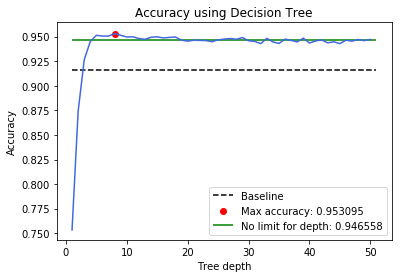

In [7]:
accuracy = []
xmin, xmax = 1, 51
bestAcc, bestM = -1, -1
for depth in range(xmin, xmax):
    model = tree.DecisionTreeClassifier(max_depth=depth)
    accuracy += [crossValidation(model, foldsX, foldsY)]

    if bestAcc < accuracy[-1]:
        bestAcc = accuracy[-1]
        bestM = model
        
setLegends('Accuracy using Decision Tree', 'Tree depth', xmin, xmax)
                               
maxAccuracy = max(accuracy)
maxAccuracyIndex = xmin + accuracy.index(maxAccuracy)
                               
X = list(range(xmin, xmax))

plt.scatter(maxAccuracyIndex, maxAccuracy, color='red', label="Max accuracy: %f"%(maxAccuracy))
plt.plot(X, accuracy, color='royalblue')
                               
model = tree.DecisionTreeClassifier(max_depth=None)
accuracyNone = crossValidation(model, foldsX, foldsY)
plt.hlines(accuracyNone, label="No limit for depth: %f"%(accuracyNone), xmin=xmin, xmax=xmax, color='green')
plt.legend();
                               
bestModels['Decision Tree'] = (maxAccuracy, bestM)

De acordo com o gráfico acima, podemos inferir que árvores muito simples (profundidade < 5) não conseguem generalizar bem os dados. Por outro lado, árvores com uma profundidade muito alta são muito complexas, não alcançando a melhor acurácia.

A árvore com profundidade __8__ alcançou a melhor acurácia, de **0.953095**. Além disto, pode-se perceber que, a partir da profundidade = 20, o valor da acurácia começa a diminuir, indicando overfiting.

---
## Support Vector Machines

O método SVM se baseia no conceito de margem, isto é, modelos que possuem margem maiores são considerados melhores. A margem é a distância da curva (do modelo) até os pontos de classes distintas mais próximos.

Um parâmetro para o método do SVM é o kernel. Esse pode ser entendido como a função que busca separar os pontos do dataset em uma nova dimensão. A utilização do kernel depende de como os dados estão dispostos no espaço.

Neste trabalho foram testados 4 kernels: Linear, Sigmoid, Polinomial e Radial Basis function.

In [8]:
accuracy = []

model = svm.SVC(kernel="linear", gamma="scale", probability=True)
accuracy += [crossValidation(model, foldsX, foldsY)]
print("Accuracy with linear kernel:     %f"%(accuracy[0]))
bestAcc, bestM = accuracy[0], model


model = svm.SVC(kernel="sigmoid", gamma="scale", probability=True)
accuracy += [crossValidation(model, foldsX, foldsY)]
print("Accuracy with sigmoid kernel:    %f"%(accuracy[1]))
if bestAcc < accuracy[-1]:
    bestAcc = accuracy[-1]
    bestM = model

model = svm.SVC(kernel="poly", gamma="scale", probability=True)
accuracy += [crossValidation(model, foldsX, foldsY)]
print("Accuracy with polinomial kernel: %f"%(accuracy[2]))
if bestAcc < accuracy[-1]:
    bestAcc = accuracy[-1]
    bestM = model
        
model = svm.SVC(kernel="rbf", gamma="scale", probability=True)
accuracy += [crossValidation(model, foldsX, foldsY)]
print("Accuracy with RBF kernel:        %f"%(accuracy[3]))
if bestAcc < accuracy[-1]:
    bestAcc = accuracy[-1]
    bestM = model

maxAccuracy = max(accuracy)
maxAccuracyIndex = 1 + accuracy.index(maxAccuracy)

bestModels['SVM'] = (maxAccuracy, bestM)

Accuracy with linear kernel:     0.951748
Accuracy with sigmoid kernel:    0.842555
Accuracy with polinomial kernel: 0.879085
Accuracy with RBF kernel:        0.936755


O kernel que consegue separar os dados da melhor forma é o linear, que alcançou a acurácia de **0.951748**.

---
## K Nearest Neighboor

O método dos K vizinhos mais próximos se baseia na ideia de inferir a classe de um ponto baseando-se na classe dos k pontos mais próximos a ele. Há dois parâmetros principais no KNN: A função que calculará a distância entre dois pontos e a função que irá predizer a classe de um ponto, de acordo com a classe dos vizinhos.

Neste trabalho foi utilizada a distância euclidiana como métrica de distância entre pontos, e para predizer a classe de um ponto, os pesos de cada vizinho deste foram proporcionais ao inverso da distância do vizinho ao ponto em questão.

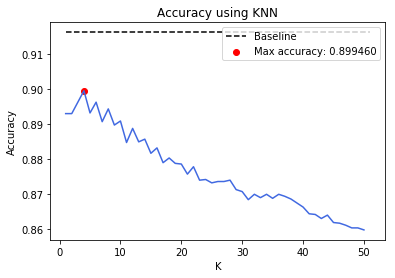

In [9]:
accuracy = []
xmin, xmax = 1, 51
bestAcc, bestM = -1, -1
for k in range(xmin, xmax):
    model = neighbors.KNeighborsClassifier(n_neighbors=k, weights="distance")
    accuracy += [crossValidation(model, foldsX, foldsY)]
    
    if bestAcc < accuracy[-1]:
        bestAcc = accuracy[-1]
        bestM = model

setLegends('Accuracy using KNN', 'K', xmin, xmax)
                               
maxAccuracy = max(accuracy)
maxAccuracyIndex = xmin + accuracy.index(maxAccuracy)
                               
X = list(range(xmin, xmax))

plt.scatter(maxAccuracyIndex, maxAccuracy, color='red', label="Max accuracy: %f"%(maxAccuracy))
plt.plot(X, accuracy, color='royalblue')
plt.legend();

bestModels['KNN'] = (maxAccuracy, bestM)

A curva do gráfico acima nos revela uma piora na acurácia com valores altos para k, a partir de k = 8.
Isso poderia ser explicado pelo fato de que, em casos onde o ponto que se quer prever a classe se encontra em uma região próxima a pontos das duas classes, a inferência da classe deste será feita com muitos pontos de ambas as classes, o que se mostrou não muito eficiente.

A melhor acurácia alcançada foi de **0.899460**, com **k = 4**.

---
## Random Forest

A ideia principal do Random Forest é similar a ideia do Boosting: Através de um boostrap construímos conjuntos $D_1, \ldots\ D_m$ a partir do conjunto original $D$. A diferença para o Boosting é a ideia de treinar diversos modelos que são independentes, isto é, que utilizam features diferentes.

Geralmente são utilizadas árvores de decisão para construir o modelo de cada $D_i$. Para treinar cada modelo foram removidas $\sqrt{|F|}$ features aleatoriamente.

Os hiperparâmetros considerados no Random Forest foram o número de árvores (isto é, $m$) e a profundidade de cada árvore. Foram realizados experimentos, e a altura da árvore que alcançou maior acurácia foi **12**.

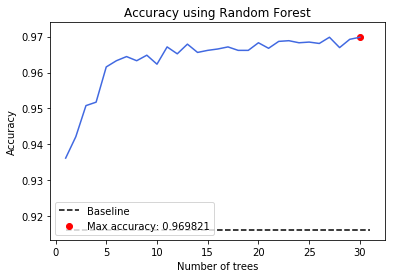

In [10]:
accuracy = []
xmin, xmax = 1, 31
bestAcc, bestM = -1, -1
for n_trees in range(xmin, xmax):
    model = ensemble.RandomForestClassifier(n_estimators=n_trees, max_depth=12)
    accuracy += [crossValidation(model, foldsX, foldsY)]

    if bestAcc < accuracy[-1]:
        bestAcc = accuracy[-1]
        bestM = model
        
setLegends('Accuracy using Random Forest', 'Number of trees', xmin, xmax)
                               
maxAccuracy = max(accuracy)
maxAccuracyIndex = xmin + accuracy.index(maxAccuracy)
                               
X = list(range(xmin, xmax))

plt.scatter(maxAccuracyIndex, maxAccuracy, color='red', label="Max accuracy: %f"%(maxAccuracy))
plt.plot(X, accuracy, color='royalblue')
plt.legend();

bestModels['Random Forest'] = (maxAccuracy, bestM)

O gráfico acima nos mostra que a acurácia do Random Forest segue uma curva logarítmica, e a partir de 10 árvores não há uma variância muito significativa na acurácia (a acurácia variou cerca de 0.2%).

A melhor acurácia alcançada foi de **0.969821**, com **30** árvores.

---
## Gradient Tree Boosting

A ideia do Boosting é construir um modelo forte a partir de modelos simples. Os modelos simples são chamados de *dumps*. O modelo final é melhorado por meio de *rounds*, onde em cada round é se cria um dump e atribui um peso maior aos exemplos que foram classificados erroneamente. 

Por consequência, o número de rounds é o parâmetro variado neste experimento. Foram analisados modelos com 50 rounds até modelos com 300 rounds.

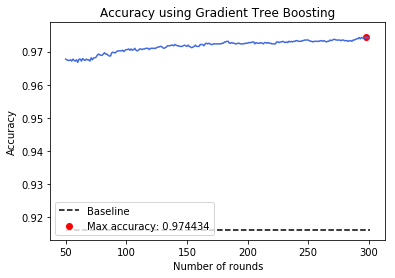

In [11]:
accuracy = []
xmin, xmax = 50, 301
bestAcc, bestM = -1, -1
for n_stages in range(xmin, xmax):
    model = ensemble.GradientBoostingClassifier(n_estimators=n_stages)
    accuracy += [crossValidation(model, foldsX, foldsY)]

    if bestAcc < accuracy[-1]:
        bestAcc = accuracy[-1]
        bestM = model
        
setLegends('Accuracy using Gradient Tree Boosting', 'Number of rounds', xmin, xmax)
                               
maxAccuracy = max(accuracy)
maxAccuracyIndex = xmin + accuracy.index(maxAccuracy)
                               
X = list(range(xmin, xmax))

plt.scatter(maxAccuracyIndex, maxAccuracy, color='red', label="Max accuracy: %f"%(maxAccuracy))
plt.plot(X, accuracy, color='royalblue')
plt.legend();
    
bestModels['Gradient Tree Boosting'] = (maxAccuracy, bestM)

A partir do gráfico acima é possível perceber que o algoritmo é bem robusto em relação ao overfiting, e isto é observado no crescente valor da acurácia conforme cresce o número de rounds.

A melhor acurácia alcançada foi de **0.974434**, com **298** rounds.

---
## Resultados

Para o dataset em questão, alguns métodos se mostraram melhores que outros, como por exemplo o Random Forest e o Gradient Tree Boosting. Abaixo se encontra a curva ROC e as métricas de precisão e revocação para todos os métodos.

### Curva ROC

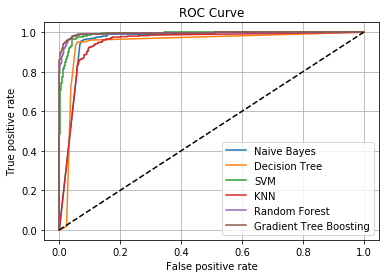

In [12]:
# Select one iteration from K-Fold
trainX, trainY = foldsX.copy(), foldsY.copy()
testX, testY = foldsX[0].copy(), foldsY[0].copy()
trainX.pop(0); trainY.pop(0)
trainX = pd.concat(trainX)
trainY = pd.concat(trainY)

precision, recall, allAccuracy = [], [], []

for method, values in bestModels.items():
    model = values[1]   
    model.fit(trainX, trainY)
    
    predict = model.predict(testX)
    probs = model.predict_proba(testX)[:,1]
    fpr, tpr, _ = metrics.roc_curve(testY, probs)
    
    allAccuracy += [values[0]]
    recall += [metrics.recall_score(testY, predict)]
    precision += [metrics.precision_score(testY, predict)]
    
    plt.plot(fpr, tpr, label=method)

plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.grid()
plt.legend();

### Precisão e revocação

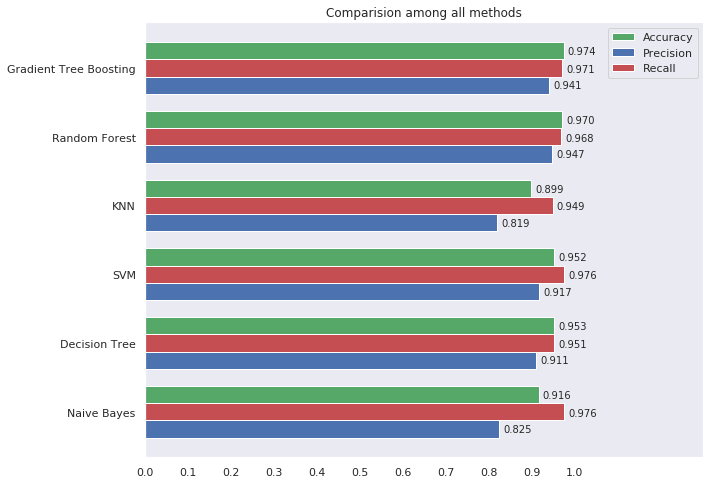

In [14]:
import seaborn as sns

sns.set(rc={'figure.figsize':(10,8)})

ax = plt.subplot(111)
X = np.array([1,2,3,4,5,6])
ax.barh(X+.25, allAccuracy, label='Accuracy', height=0.25, color='g', align='center')
ax.barh(X-.25, precision, label='Precision', height=0.25, color='b', align='center')
ax.barh(X, recall, label='Recall', height=0.25, color='r', align='center')
ax.set_yticklabels(['Naive Bayes'] + list(bestModels.keys()))
ax.grid()
plt.title("Comparision among all methods")
plt.xlim(0.0,1.3)
plt.xticks(np.arange(0.0,1.1,0.1))
ax.legend();

for i in range(1,7):
    plt.text(allAccuracy[i-1]+0.01, i+.20,"%.3f"%(allAccuracy[i-1]), fontsize=10)
    plt.text(precision[i-1]+0.01, i-0.3, "%.3f"%(precision[i-1]), fontsize=10)
    plt.text(recall[i-1]+0.01, i-0.06, "%.3f"%(recall[i-1]), fontsize=10)

---
## Referências

[1] Slides da disciplina. Acesso em: 21 de maio de 2019. Disponível em: \<https://dcc.ufmg.br/adrianov/ml \>

[2] Pedregosa, F; Varoquaux, G; Gramfort, A; Michel, V; Thirion, B; Grisel, O; Blondel, M; Prettenhofer, P; Weiss, R; Dubourg, V; Vanderplas, J; Passos, A; Cournapeau, D; Brucher, M; Perrot, M; Duchesnay, E.  **Scikit Learn**, Journal of Machine Learning Research. Acesso em: 21 de maio de 2019. Disponível em: \<https://scikit-learn.org \>